In [17]:
import os
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
import tensorly as tl
import numpy as np

In [35]:
MVBS_path = '/Users/wu-jung/code_git/ooi_sonar/zplsc_data_2015fall/nc_MVBS_envFromFile/'
MVBS_file = '20150817-20151017_MVBS_time_from_Sv_rangeBin5_all.nc'

In [36]:
MVBS = xr.open_dataset(os.path.join(MVBS_path, MVBS_file))
MVBS

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 8928, range_bin: 41)
Coordinates:
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 7 8 ... 33 34 35 36 37 38 39 40
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * ping_time  (ping_time) datetime64[ns] 2015-08-17 ... 2015-10-17T23:16:40
Data variables:
    MVBS       (range_bin, ping_time, frequency) float64 ...
    range      (ping_time, range_bin) float64 ...

In [2]:
MVBS_PCP_path = '/Users/wu-jung/code_git/ooi_sonar/zplsc_data_2015fall/nc_PCP_envFromFile/'
MVBS_rpca_file = '20150817-20151017_MVBS_time_from_Sv_rangeBin5_rpca.nc'

In [3]:
MVBS_rpca = xr.open_dataset(os.path.join(MVBS_PCP_path, MVBS_rpca_file))
MVBS_rpca

<xarray.Dataset>
Dimensions:    (date: 62, depth: 37, frequency: 3, hour: 144)
Coordinates:
  * date       (date) datetime64[ns] 2015-08-17 2015-08-18 ... 2015-10-17
  * frequency  (frequency) int64 38000 120000 200000
  * depth      (depth) float64 184.0 179.0 174.0 169.0 ... 14.91 9.943 4.972
  * hour       (hour) float64 0.0 0.1667 0.3333 0.5 ... 23.33 23.5 23.67 23.83
Data variables:
    low_rank   (date, frequency, depth, hour) float64 ...
    sparse     (date, frequency, depth, hour) float64 ...

In [4]:
low_rank = MVBS_rpca['low_rank']
low_rank.shape

(62, 3, 37, 144)

In [5]:
low_rank = low_rank.values.reshape([62,-1])
low_rank.shape

(62, 15984)

In [6]:
low_rank_nonneg = low_rank - low_rank.min()

## Classic NMF

In [68]:
model = NMF(n_components=3, init='random', random_state=0)

In [69]:
H = model.fit_transform(low_rank_nonneg)
W = model.components_

In [70]:
(W.shape, H.shape)

((3, 15984), (62, 3))

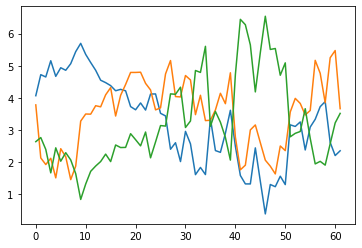

In [71]:
hlines = plt.plot(H)

In [73]:
W_reorg = W.reshape(3,3,37,144)

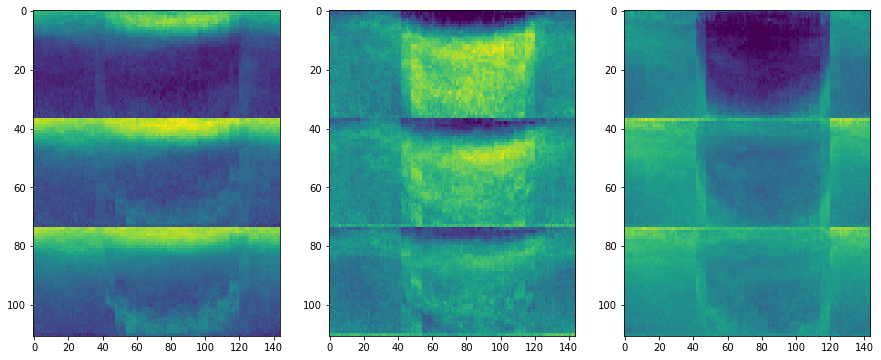

In [76]:
fig, ax = plt.subplots(1,3,figsize=(15,6))
for icomp in range(3):
    ax[icomp].imshow(tl.unfold(tl.tensor(W_reorg[icomp,:,:,:].squeeze()),mode=2).T,
                     aspect='auto')

## Check similarity between days

In [77]:
from scipy.spatial.distance import pdist, squareform

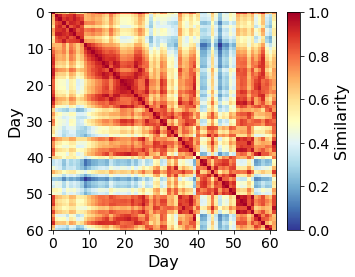

In [78]:
# Normalize the activation coefficients
k = H.T
k_norm = k.T-k.min(axis=1)
k_norm = k_norm/k_norm.max(axis=0)
D = pdist(k_norm, 'euclidean')
D_square = squareform(D)
similarity_m = 1-D_square/D_square.max()

# Check similarity between any two days within the observation period
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
plt.imshow(similarity_m,cmap='RdYlBu_r')
plt.xticks(np.arange(0,62,10),fontsize=14)
plt.yticks(np.arange(0,62,10),fontsize=14)
plt.xlabel('Day',fontsize=16)
plt.ylabel('Day',fontsize=16)

cbaxes = fig.add_axes([0.8, 0.125, 0.03, 0.755]) 
cbar = plt.colorbar(cax = cbaxes)  
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_ylabel('Similarity', rotation=90, fontsize=16)
plt.show()


## Check reconstruction error

In [79]:
recon = np.matmul(H,W)

In [80]:
recon_da = xr.DataArray(np.moveaxis(recon.reshape([62, 3, 37, 144]),[0,1,2],[2,0,1]).reshape([3,37,-1]),
                        coords=[('frequency', MVBS_rpca['frequency']),
                                ('depth', MVBS_rpca['depth']),
                                ('ping_time', MVBS['ping_time'])])

In [81]:
rpca_da = xr.DataArray(np.moveaxis(MVBS_rpca['low_rank'].values,[0,1,2],[2,0,1]).reshape([3,37,-1])-
                       MVBS_rpca['low_rank'].values.min(),
                       coords=[('frequency', MVBS_rpca['frequency']),
                                ('depth', MVBS_rpca['depth']),
                                ('ping_time', MVBS['ping_time'])])

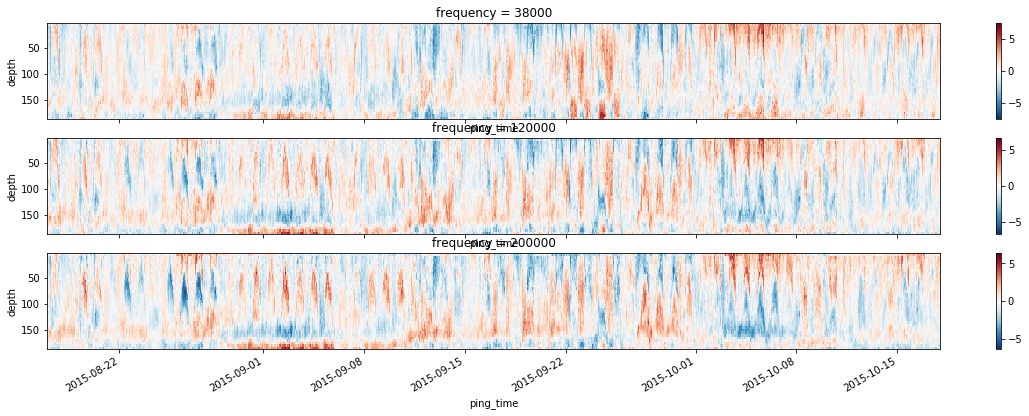

In [82]:
fig, ax = plt.subplots(3, 1, figsize=(20,6), sharex=True)
for ifreq, freq in enumerate([38000,120000,200000]):
    (recon_da-rpca_da).sel(frequency=freq).plot(ax=ax[ifreq], yincrease=False)